# Exercises

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

In [1]:
import numpy as np
import scipy
import scipy.stats  
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import poisson
from tqdm import tqdm
import seaborn as sns



track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [2]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [3]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [4]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [5]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

In [6]:
x,t,spikes = out_data['x'],out_data['t'],out_data['spikes']
track_length = out_data['track_length']
fps = out_data['fps'] 
n_cells = len(spikes)

In [7]:
def plot_unit(i):
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [8]:
# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

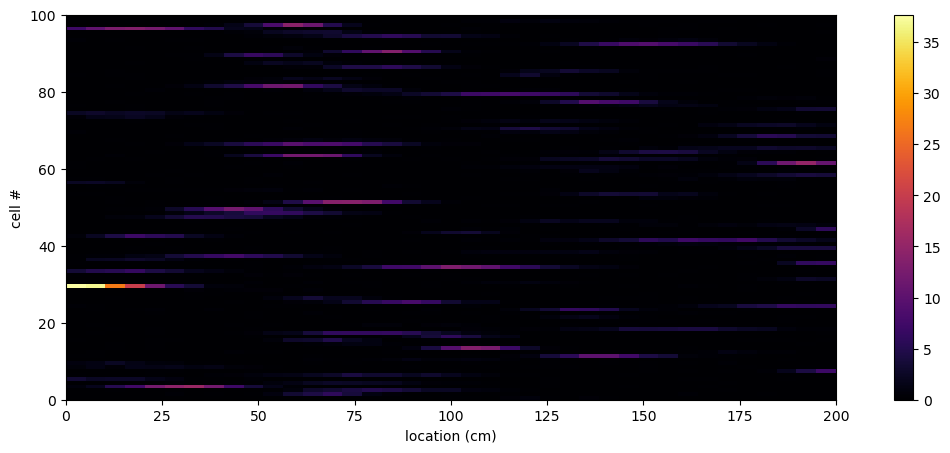

In [9]:
# let's look at the ratemaps
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

In [10]:
spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

In [11]:
# code decoding

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   


100%|██████████| 5582/5582 [00:08<00:00, 691.14it/s]


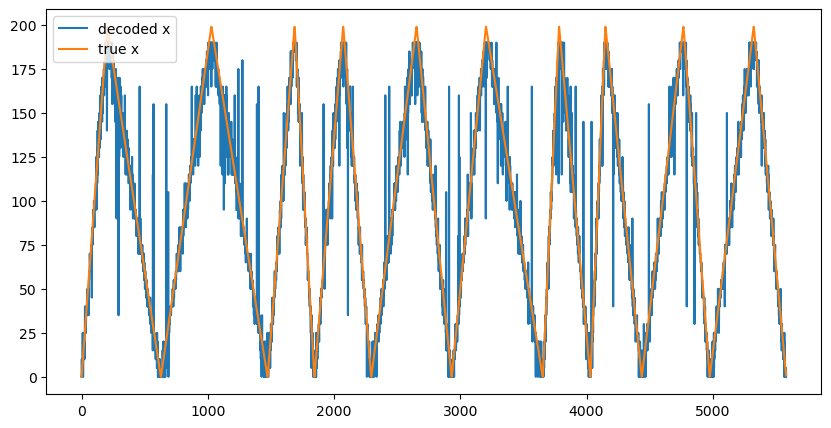

In [12]:
plt.figure(figsize=(10,5))
plt.plot(x_decoded,label= 'decoded x')
plt.plot(true_x,label = 'true x')
plt.legend()

Median error: 3.640261567057955 cm


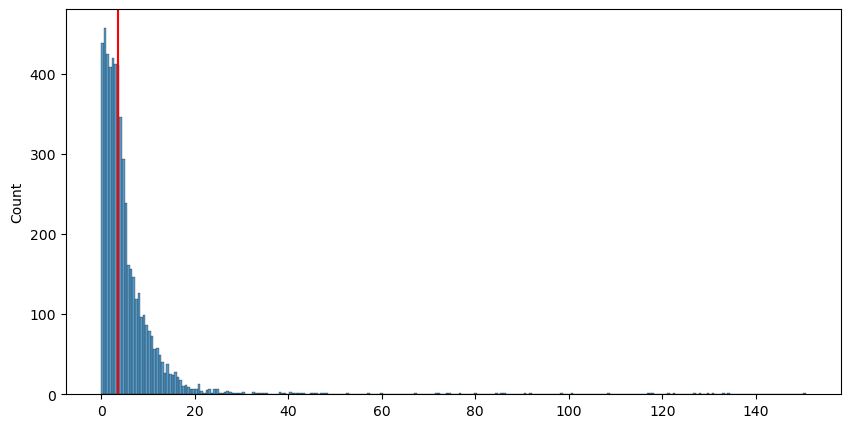

In [13]:
# error distribution
mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
print(f'Median error: {np.nanmedian(mse)} cm')

setting different fractions of the data samples

Using 0.1 data samples


100%|██████████| 5582/5582 [00:01<00:00, 5262.66it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.129716981132077 cm
Using 0.2 data samples


100%|██████████| 5582/5582 [00:02<00:00, 2725.10it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.7894736842105203 cm
Using 0.30000000000000004 data samples


100%|██████████| 5582/5582 [00:02<00:00, 2104.01it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.4459776678086627 cm
Using 0.4 data samples


100%|██████████| 5582/5582 [00:03<00:00, 1601.51it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.5421623756854714 cm
Using 0.5 data samples


100%|██████████| 5582/5582 [00:04<00:00, 1290.68it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.60633484162895 cm
Using 0.6 data samples


100%|██████████| 5582/5582 [00:05<00:00, 1076.16it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.7195071045733243 cm
Using 0.7000000000000001 data samples


100%|██████████| 5582/5582 [00:05<00:00, 930.96it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.652105616153051 cm
Using 0.8 data samples


100%|██████████| 5582/5582 [00:06<00:00, 836.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.716921454928844 cm
Using 0.9 data samples


100%|██████████| 5582/5582 [00:07<00:00, 753.01it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.779510022271708 cm
Using 1.0 data samples


100%|██████████| 5582/5582 [00:08<00:00, 694.96it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.640261567057955 cm


Text(0, 0.5, 'Median error (cm)')

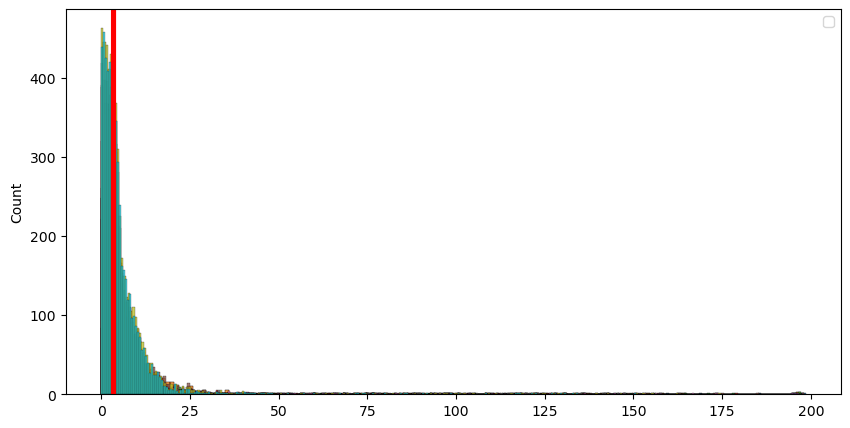

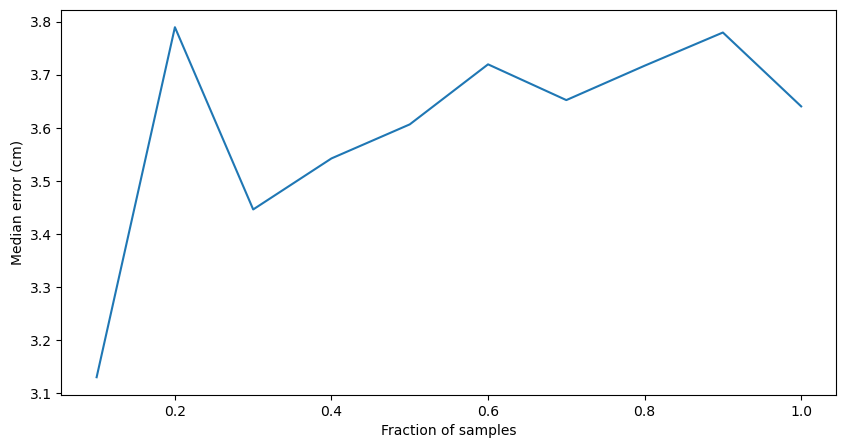

In [14]:
x,t,spikes = out_data['x'],out_data['t'],out_data['spikes']
track_length = out_data['track_length']
fps = out_data['fps'] 
median_errors = []
spikes_out = spikes.copy()
# we will use only a fraction of the cells
fractions = np.linspace(0.1,1,10)
for i in range(len(fractions)):
    fraction = fractions[i]

    # Create a copy of spikes for each iteration
    spikes_in = spikes_out.copy()  

    # Select first fraction of spikes
    for cell_idx in range(len(spikes_in)):
        spikes_in[cell_idx] = spikes_in[cell_idx][:int(fraction*len(spikes_in[cell_idx]))]

    print(f'Using {fraction} data samples')
    # we compute the poistion at which each spike was emitted
    spikes = spikes_in
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 
    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape
    # code decoding

    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for j in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   
    # error distribution
    mse = np.sqrt((true_x-x_decoded)**2)
    sns.histplot(mse)
    plt.axvline(x = np.nanmedian(mse),c='r')
    plt.legend()
    print(f'Median error: {np.nanmedian(mse)} cm')
    median_errors.append(np.nanmedian(mse))

plt.figure()
plt.plot(fractions,median_errors)
plt.xlabel('Fraction of samples')
plt.ylabel('Median error (cm)')


Using fractions of samples actually gets better results for some lower fractions. This likely is because the decoding procedure produces failures and these are not uniform across the samples. This is why we can see the median error fluctuating.

### B ###

Total number of cells: 100
Using 10 cells


100%|██████████| 5582/5582 [00:03<00:00, 1793.62it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 8.914343360234781 cm
Using 20 cells


100%|██████████| 5582/5582 [00:04<00:00, 1339.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 7.036549732013164 cm
Using 30 cells


100%|██████████| 5582/5582 [00:05<00:00, 980.66it/s] 
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 6.2913231027637835 cm
Using 40 cells


100%|██████████| 5582/5582 [00:06<00:00, 879.95it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 5.724524726450284 cm
Using 50 cells


100%|██████████| 5582/5582 [00:06<00:00, 819.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 5.24520960281918 cm
Using 60 cells


100%|██████████| 5582/5582 [00:07<00:00, 774.73it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 4.619038633088586 cm
Using 70 cells


100%|██████████| 5582/5582 [00:07<00:00, 783.21it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 4.428571428571431 cm
Using 80 cells


100%|██████████| 5582/5582 [00:07<00:00, 764.58it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 4.031830238726801 cm
Using 90 cells


100%|██████████| 5582/5582 [00:07<00:00, 743.29it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.8144796380090327 cm
Using 100 cells


100%|██████████| 5582/5582 [00:07<00:00, 723.28it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Median error: 3.640261567057955 cm


Text(0, 0.5, 'Median error (cm)')

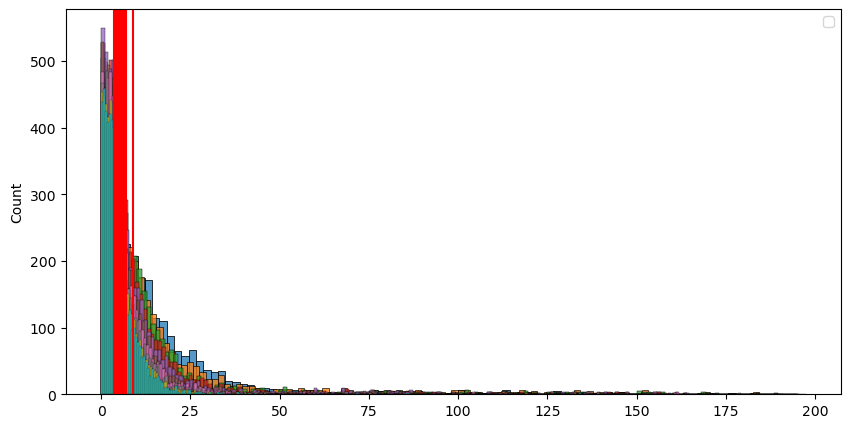

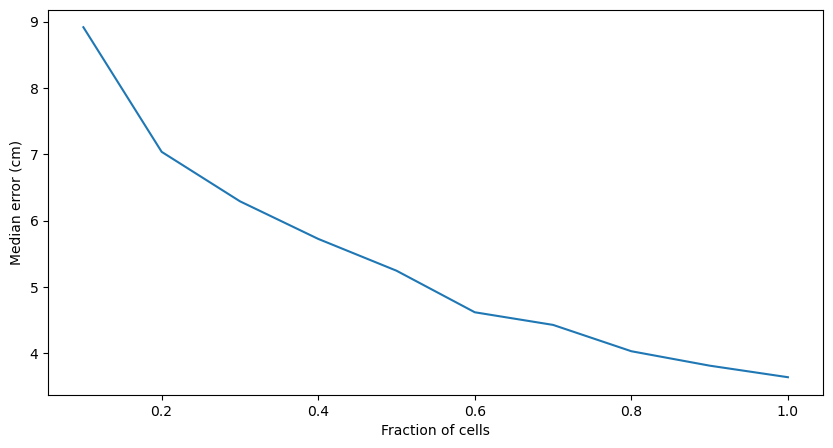

In [15]:
x,t,spikes = out_data['x'],out_data['t'],out_data['spikes']
track_length = out_data['track_length']
fps = out_data['fps'] 
n_cells_out = len(spikes)
spikes_out = spikes
print(f'Total number of cells: {n_cells_out}')
median_errors = []
# we will use only a fraction of the cells
fractions = np.linspace(0.1,1,10)
for i in range(len(fractions)):
    fraction = fractions[i]
    n_cells = int(fraction*n_cells_out)
    spikes = spikes_out[:n_cells]
    print(f'Using {n_cells} cells')
    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 
    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape
    # code decoding

    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for j in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   
    # error distribution
    mse = np.sqrt((true_x-x_decoded)**2)
    sns.histplot(mse)
    plt.axvline(x = np.nanmedian(mse),c='r')
    plt.legend()
    print(f'Median error: {np.nanmedian(mse)} cm')
    median_errors.append(np.nanmedian(mse))

plt.figure()
plt.plot(fractions,median_errors)
plt.xlabel('Fraction of cells')
plt.ylabel('Median error (cm)')


The median error goes down with the amount of cells. This is because the more data cells we have, the more information we have to decode the position.

### C ###

100%|██████████| 5170/5170 [00:08<00:00, 631.45it/s]


Median error: 3.4164383561643774 cm


100%|██████████| 5170/5170 [00:07<00:00, 663.30it/s]


Median error: 3.472340425531911 cm


100%|██████████| 5170/5170 [00:07<00:00, 652.09it/s]


Median error: 3.506274541703334 cm


100%|██████████| 5170/5170 [00:08<00:00, 639.40it/s]


Median error: 3.714285714285708 cm


100%|██████████| 5170/5170 [00:07<00:00, 685.05it/s]


Median error: 3.72183255399689 cm


100%|██████████| 5170/5170 [00:07<00:00, 703.47it/s]


Median error: 3.7894736842105203 cm


100%|██████████| 5170/5170 [00:07<00:00, 705.60it/s]


Median error: 3.826381035232714 cm


100%|██████████| 5170/5170 [00:07<00:00, 711.16it/s]


Median error: 3.840918315575834 cm


100%|██████████| 5170/5170 [00:07<00:00, 690.32it/s]


Median error: 3.9086212718477213 cm


100%|██████████| 5170/5170 [00:07<00:00, 658.21it/s]


Median error: 3.883690457838753 cm


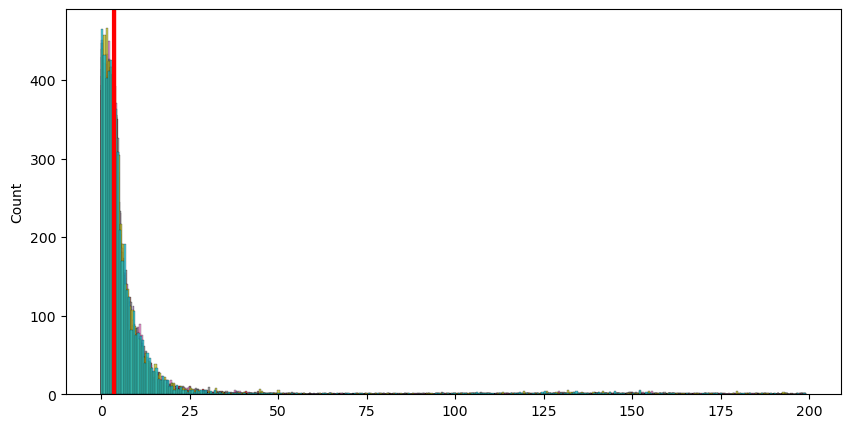

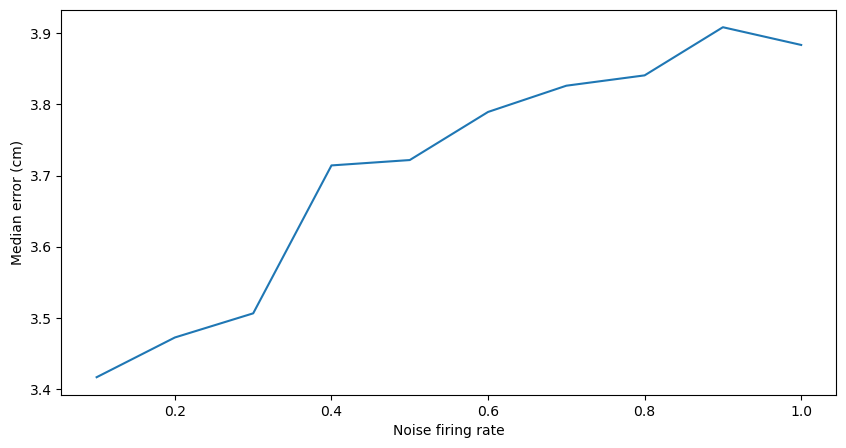

In [32]:
import numpy as np
import scipy
import scipy.stats  
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = np.linspace(0.1,1,10)
mse_list = []
for noise_firing_rate in noise_firing_rate:
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    import pickle

    file_name = 'linear_track_data.pickle' # change this name when you save new data

    out_data = {}
    out_data['x'] = x
    out_data['t'] = t
    out_data['spikes'] = spikes
    out_data['track_length'] = track_length
    out_data['fps'] = fps

    with open('data/'+file_name,'wb') as f:
        pickle.dump(out_data,f)
    x,t,spikes = out_data['x'],out_data['t'],out_data['spikes']
    track_length = out_data['track_length']
    fps = out_data['fps'] 
    n_cells = len(spikes)
    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 
    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape
    # code decoding
    from scipy.stats import poisson

    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    # error distribution
    mse = np.sqrt((true_x-x_decoded)**2)
    mse_list.append(np.nanmedian(mse))
    sns.histplot(mse)
    plt.axvline(x = np.nanmedian(mse),c='r')
    print(f'Median error: {np.nanmedian(mse)} cm')

plt.figure()
noise_firing_rate = np.linspace(0.1,1,10)
plt.plot(noise_firing_rate,mse_list)
plt.xlabel('Noise firing rate')
plt.ylabel('Median error (cm)')
plt.show()

The more noise there is in the data, the higher the median error. This is expected as the noise in the data makes it harder to decode the position of the animal.

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


### Code for data generation

In [16]:
import numpy as np
import scipy
import scipy.stats  
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [17]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [18]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [19]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [20]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

In [21]:
x,t,spikes = out_data['x'],out_data['t'],out_data['spikes']
track_length = out_data['track_length']
fps = out_data['fps'] 
n_cells = len(spikes)

In [22]:
def plot_unit(i):
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [23]:
# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

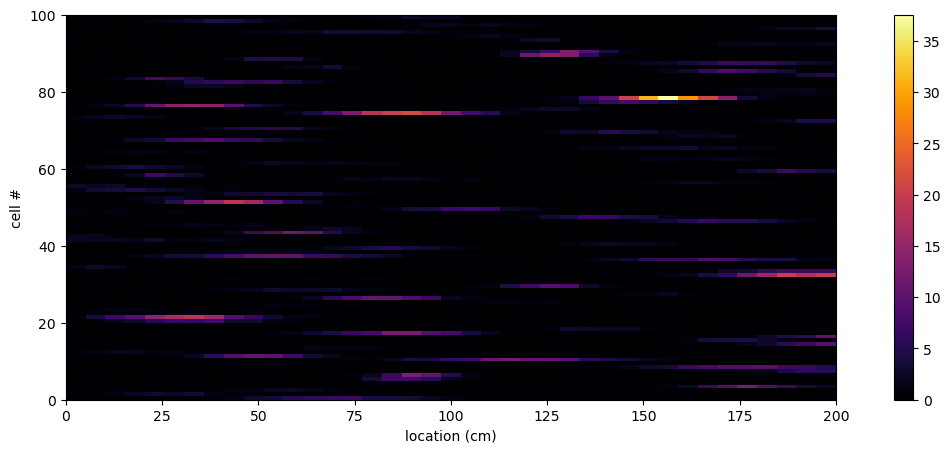

In [24]:
# let's look at the ratemaps
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

In [25]:
spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

In [26]:
# code decoding
from scipy.stats import poisson

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   


100%|██████████| 3993/3993 [00:05<00:00, 689.51it/s]


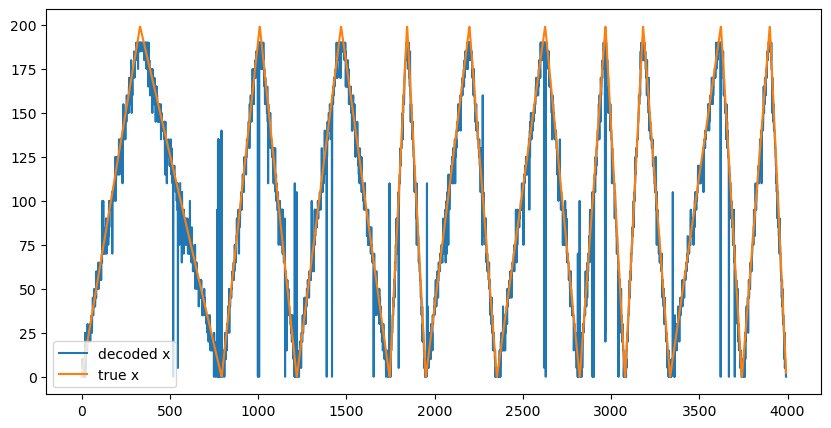

In [27]:
plt.figure(figsize=(10,5))
plt.plot(x_decoded,label= 'decoded x')
plt.plot(true_x,label = 'true x')
plt.legend()

Median error: 3.386081824143673 cm


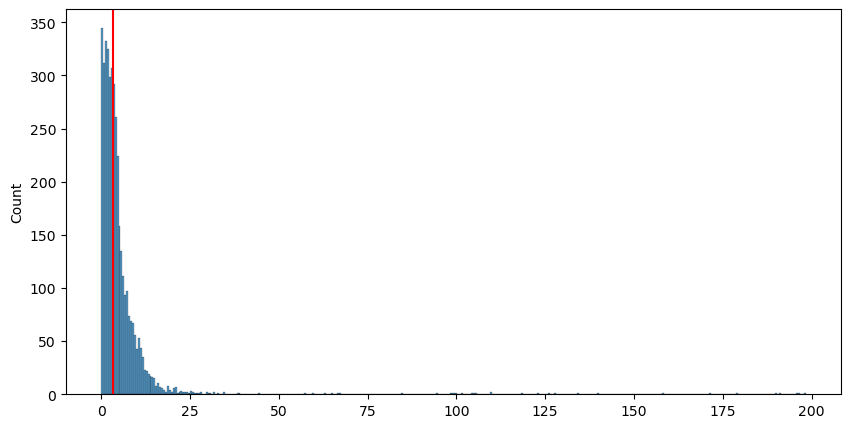

In [28]:
# error distribution
mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
print(f'Median error: {np.nanmedian(mse)} cm')